In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math

# Preliminary notes

* In this document, whenever *distance* is mentioned, it is relative to the diameter of the hit circles of the map. Therefore a distance of 1 is equal to one hit circle diameter, etc.

# Previous object correction

The *previous object correction* is concerned with the three-object movement between: the second-last, the last, and the currently-considered object.

This correction does not apply, if:

* the second last-object does not exist or was a spinner,
* the last and the current object are in the same spot (are on a stack).

Depending on the proportions of durations of the (2nd last -> last) and (last -> current) movements, there are three mutually-exclusive cases to consider:

1. The (last -> current) movement was *longer* than the previous by more than 40% - means the player is *slowing down*.
2. The (last -> current) movement was *shorter* than the previous by more than 40% - means the player is *speeding up*.
3. The two movements were relatively the same duration.

Cases (1) and (2) are additionally discarded if the (2nd last -> last) movement had zero distance travelled.

## Case 1 (slowing down)

In case (1), the correction is dependent on two main factors: the angle between object pairs (`angleCorrection`), or rather its cosine (`movementAngleCosine`), and the (2nd last -> last) distance (`movingness`). The first is given by the following plot:

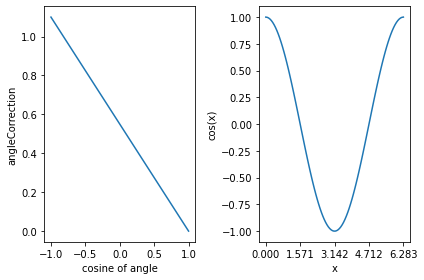

In [56]:
xs = [-1, 1]
ys = [1.1, 0]

fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.set_ylabel("angleCorrection")
ax1.set_xlabel("cosine of angle")
plt.plot(xs, ys)

xs = np.linspace(0, 2 * math.pi, 100)
ys = np.cos(xs)
ax2 = fig.add_subplot(122)
ax2.set_ylabel("cos(x)")
ax2.set_xlabel("x")
ax2.set_xticks(np.linspace(0, 2 * math.pi, 5))
plt.plot(xs, ys)

fig.tight_layout()

Merging these plots together, to show the direct relationship between the angle and the correction, yields

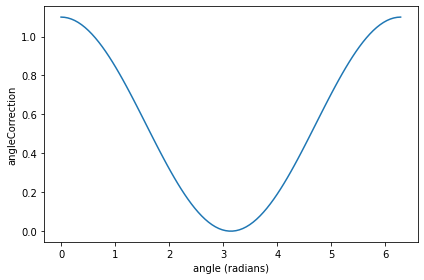

In [5]:
xs = np.linspace(0, 2 * math.pi, 100)
ys = (np.cos(xs) + 1) / 2 * 1.1

fig = plt.figure()

ax = fig.add_subplot()
ax.set_xlabel('angle (radians)')
ax.set_ylabel('angleCorrection')
plt.plot(xs, ys)

fig.tight_layout()

The cosine has a value of 1 for the zero angle and a value of -1 for the 180 degree angle. Note that the angle whose cosine is being calculated here is anchored at the last object, which is in the middle of the sequence of (2nd last -> last -> current). Therefore an angle of 180 degrees anchored there actually looks like a straight line.

This means that in regards of this multiplier, going back in the direction the player just moved in results in nullification of this factor, while continuing in a straight line results in the maximum amplification of 1.1.

The second factor is given by the following plot:

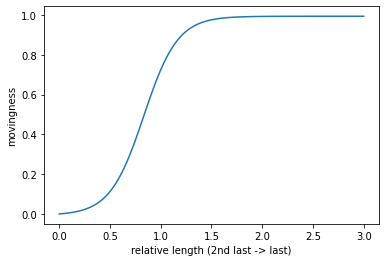

In [3]:
def logistic(xs):
    return 1 / (np.exp(-xs) + 1)

xs = np.linspace(0, 3, 100)
ys = logistic(xs * 6 - 5) - logistic(-5)

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel("movingness")
ax.set_xlabel("relative length (2nd last -> last)")
plt.plot(xs, ys)

The resulting total correction in this case is given by `1.5 * movingness * angleCorrection`.

What this means in practice:

* The range of this correction is \[0, 1.5 * 1.1 = 1.65\]
* The more straight-line the movement between the three objects is, the closer to zero the correction is
* Shorter movements result in a smaller value
* Longer movements result in a bigger value

## Case 2 (speeding up)